In [1]:
import pandas as pd
pd.set_option('display.max_columns',10000)
import numpy as np
from datetime import date
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('listings.csv')
df.head(5)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20220106171342,2022-01-07,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi<br />...,"Indische Buurt (""Indies Neighborhood"") is a ne...",https://a0.muscache.com/pictures/10272854/8dcc...,3159,https://www.airbnb.com/users/show/3159,Daniel,2008-09-24,"Amsterdam, Noord-Holland, The Netherlands","Upon arriving in Amsterdam, one can imagine as...",within an hour,100%,100%,t,https://a0.muscache.com/im/users/3159/profile_...,https://a0.muscache.com/im/users/3159/profile_...,Indische Buurt,1,1,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Amsterdam, North Holland, Netherlands",Oostelijk Havengebied - Indische Buurt,NaN,52.36435,4.94358,Private room in rental unit,Private room,2,NaN,1.5 shared baths,1.0,2.0,"[""Security cameras on property"", ""Refrigerator...",$59.00,3,28,3.0,3.0,1125.0,1125.0,3.0,1125.0,NaN,t,28,51,51,51,2022-01-07,285,7,0,2009-03-30,2021-11-21,4.89,4.93,5.00,4.97,4.98,4.68,4.82,0363 5F3A 5684 6750 D14D,t,1,0,1,0,1.83
1,20168,https://www.airbnb.com/rooms/20168,20220106171342,2022-01-06,Studio with private bathroom in the centre 1,17th century Dutch townhouse in the heart of t...,Located just in between famous central canals....,https://a0.muscache.com/pictures/69979628/fd6a...,59484,https://www.airbnb.com/users/show/59484,Alexander,2009-12-02,"Amsterdam, Noord-Holland, The Netherlands",+ (Phone number hidden by Airbnb),within an hour,100%,96%,f,https://a0.muscache.com/im/pictures/user/65092...,https://a0.muscache.com/im/pictures/user/65092...,Grachtengordel,2,2,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Amsterdam, North Holland, Netherlands",Centrum-Oost,NaN,52.36407,4.89393,Private room in townhouse,Private room,2,NaN,1 private bath,1.0,1.0,"[""Fire extinguisher"", ""Carbon monoxide alarm"",...",$106.00,1,365,1.0,1.0,1125.0,1125.0,1.0,1125.0,NaN,t,0,0,0,0,2022-01-06,339,0,0,2010-03-02,2020-04-09,4.44,4.69,4.79,4.63,4.62,4.87,4.49,0363 CBB3 2C10 0C2A 1E29,t,2,0,2,0,2.35
2,27886,https://www.airbnb.com/rooms/27886,20220106171342,2022-01-06,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,"Central, quiet, safe, clean and beautiful.",https://a0.muscache.com/pictures/02c2da9d-660e...,97647,https://www.airbnb.com/users/show/97647,Flip,2010-03-23,"Amsterdam, Noord-Holland, The Netherlands","Marjan works in ""eye"" the dutch filmmuseum, an...",within an hour,100%,100%,t,https://a0.muscache.com/im/users/97647/profile...,https://a0.muscache.com/im/users/97647/profile...,Westelijke Eilanden,1,1,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Amsterdam, North Holland, Netherlan

In [3]:
df.shape

(5597, 74)

# 1. Explore the data

In [4]:
df.index.rename('listingID', inplace = True)

### a. Explore number of Null values for each attribute
why: If too many null values, consider either fill null values or drop attribute in data preparation later.

In [5]:
col = []
na = []
for i in df.columns:
    col.append(i)
    na.append("{:.2%}".format(df[i].isna().sum()/df.shape[0]))
n_null = pd.Series(dict(zip(col,na)))
n_null

id                                              0.00%
listing_url                                     0.00%
scrape_id                                       0.00%
last_scraped                                    0.00%
name                                            0.00%
                                                ...  
calculated_host_listings_count                  0.00%
calculated_host_listings_count_entire_homes     0.00%
calculated_host_listings_count_private_rooms    0.00%
calculated_host_listings_count_shared_rooms     0.00%
reviews_per_month                               9.42%
Length: 74, dtype: object

<b>
    
Observations:
    
1. Four attributes have 100% null values: "neighbourhood_group_cleansed", "bathrooms", "calendar_updated"
2. Nineteen attributes have 1% - 43% data points with null values. Consider either removing or filling them.
    
<b>

# 2. Prepare the Data
### a. Start by dropping columns that, under common sense, have no prediction ability on price of listings.
- id
- listing_url
- scrape_id
- picture_url
- host_id
- host_url
- host_name
- calendar_last_scraped
- last_scraped
- license
- neighbourhood

In [6]:
# step 1
df.drop(columns = ['id','listing_url','scrape_id','picture_url',
                   'host_id','host_url','host_name','host_thumbnail_url','host_picture_url',
                   'neighbourhood','calendar_last_scraped', 'last_scraped',
                   'license', 'host_neighbourhood','name','description'], inplace = True)

### b. Drop columns that include too many null values.
- neighbourhood_group_cleansed
- bathrooms
- calendar_updated

In [7]:
df.drop(columns = ['neighbourhood_group_cleansed','bathrooms','calendar_updated'], inplace = True)

### c. Examine DataFrame
Determine what are the remaining columns with null values and how to deal with them.

In [8]:
def null_check(df):
    col = []
    na = []
    for i in df.columns:
        if df[i].isna().sum() != 0:
            col.append(i)
            na.append("{:.2%}".format(df[i].isna().sum()/df.shape[0]))
    n_null = pd.Series(dict(zip(col,na)))
    return n_null

In [9]:
null_check(df)

neighborhood_overview          28.84%
host_location                   0.23%
host_about                     36.41%
host_response_time             29.91%
host_response_rate             29.91%
host_acceptance_rate           17.99%
bathrooms_text                  0.29%
bedrooms                        5.61%
beds                            1.80%
minimum_minimum_nights          0.02%
maximum_minimum_nights          0.02%
minimum_maximum_nights          0.02%
maximum_maximum_nights          0.02%
minimum_nights_avg_ntm          0.02%
maximum_nights_avg_ntm          0.02%
first_review                    9.42%
last_review                     9.42%
review_scores_rating            9.42%
review_scores_accuracy          9.58%
review_scores_cleanliness       9.58%
review_scores_checkin           9.58%
review_scores_communication     9.58%
review_scores_location          9.58%
review_scores_value             9.58%
reviews_per_month               9.42%
dtype: object

### d. Transform attributes to be ML-ready


### 1. handle attributes with missing values 
### (no imputation)
For questions regarding my approach of handlingmissing values, check this:

https://medium.com/analytics-vidhya/ways-to-handle-categorical-column-missing-data-its-implementations-15dc4a56893

In [10]:
print(str(len(null_check(df))) + ' attributes still have missing values')

25 attributes still have missing values


In [11]:
# transform neighborhood_overview into 1 if not null and 0 if null
df['neighborhood_overview'] = df['neighborhood_overview'].notna().astype(int)

In [12]:
# transform host_about into 1 if not null and 0 if null
df['host_about'] = df['host_about'].notna().astype(int)

In [13]:
# add an additional attribute: 1 if host_response_time is null, 0 if not null
df['null_response_history'] = df['host_response_time'].isna().astype(int)

In [14]:
# transform host_response_time
df['host_response_time'] = df['host_response_time'].replace({'within an hour':1,
                                                             'within a day':2,
                                                             'within a few hours':3,
                                                             'a few days or more':4})

In [15]:
# add an additional attribute: 1 if host_acceptance_rate is null, 0 if not null
df['null_request_history'] = df['host_acceptance_rate'].isna().astype(int)

In [16]:
# fill host_response_time null values with 1, which is 'within an hour'
df['host_response_time'] = df['host_response_time'].fillna(1)

In [17]:
# transform bathrooms_text
df['bathrooms_text'] = df['bathrooms_text'].fillna('1 bath')
df = pd.get_dummies(df, columns = ['bathrooms_text'])

In [18]:
# add null_bedrooms: if bedrooms is null 1, else 0
# fill null values
df['null_bedrooms'] = df['bedrooms'].isna().astype(int)
df['bedrooms'] = df['bedrooms'].fillna(1.0)

In [19]:
# add null_beds: if bed is null 1, else 0
df['null_beds'] = df['beds'].isna().astype(int)
df['beds'] = df['beds'].fillna(1.0)

### (imputation) The reason we want to do this step separately is to avoid data leakage. We want to impute missing values based on training data only.

In [20]:
# transform price
import re
df['price'] = df['price'].str.extract(pat = '([\d]+)').astype(float)
# remove outlier rows
df = df[df['price']!= 0.0]

In [21]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(df.drop(columns = ['price']), df['price'], random_state = 1)

In [22]:
# fill host_response_rate null values with training set's median
def converter(series):
    result = []
    for i in series:
        if type(i) == str:
            result.append(float(i.strip('%'))/100)
        else:
            result.append(i)
    return pd.Series(result)
X_train['host_response_rate'] = converter(X_train['host_response_rate'])
X_test['host_response_rate'] = converter(X_test['host_response_rate'])

X_train['host_response_rate'] = X_train['host_response_rate'].fillna(X_train['host_response_rate'].median())
X_test['host_response_rate'] = X_test['host_response_rate'].fillna(X_train['host_response_rate'].median())

In [23]:
# fill host_acceptance rate null values with median
X_train['host_acceptance_rate'] = converter(X_train['host_acceptance_rate'])
X_test['host_acceptance_rate'] = converter(X_test['host_acceptance_rate'])

X_train['host_acceptance_rate'] = X_train['host_acceptance_rate'].fillna(X_train['host_acceptance_rate'].median())
X_test['host_acceptance_rate'] = X_test['host_acceptance_rate'].fillna(X_train['host_acceptance_rate'].median())

In [24]:
# fill host_location null values with mode
X_train['host_location'] = X_train['host_location'].fillna('Amsterdam, North Holland, Netherlands')
X_test['host_location'] = X_test['host_location'].fillna('Amsterdam, North Holland, Netherlands')
# transform host_location into host_in_Amsterdam
Amsterdam = ['Amsterdam, North Holland, Netherlands','Amsterdam, North Holland, The Netherlands', 
             'Amsterdam, Noord-Holland, The Netherlands','Amsterdam, Noord-Holland, Netherlands']
X_train['host_in_Amsterdam'] = X_train['host_location'].isin(Amsterdam).astype(int)
X_train.drop(columns = ['host_location'], inplace = True)
X_test['host_in_Amsterdam'] = X_test['host_location'].isin(Amsterdam).astype(int)
X_test.drop(columns = ['host_location'], inplace = True)

In [25]:
# transform first_review and last_review into days_since_x_review
def date_transformer(date_string_series):
    result = []
    for date in date_string_series:
        if type(date) == str:
            result.append((datetime.strptime(date,'%Y-%m-%d')).date())
        else:
            result.append(date)
    return pd.Series(result)
X_train['days_since_first_review'] = pd.to_timedelta(date(2022,1,1) - date_transformer(X_train['first_review']), 
                                                errors = 'coerce').dt.days
X_train['days_since_last_review'] = pd.to_timedelta(date(2022,1,1) - date_transformer(X_train['last_review']), 
                                                errors = 'coerce').dt.days
X_test['days_since_first_review'] = pd.to_timedelta(date(2022,1,1) - date_transformer(X_test['first_review']), 
                                                errors = 'coerce').dt.days
X_test['days_since_last_review'] = pd.to_timedelta(date(2022,1,1) - date_transformer(X_test['last_review']), 
                                                errors = 'coerce').dt.days

# drop first_review and last_review
X_train = X_train.drop(columns = ['first_review','last_review'])
X_test = X_test.drop(columns = ['first_review','last_review'])


# add new column no_reviews
X_train['no_reviews'] = X_train['reviews_per_month'].isna().astype(int)
X_test['no_reviews'] = X_test['reviews_per_month'].isna().astype(int)


# fill null values with avg
for attribute in ['review_scores_rating','reviews_per_month','days_since_first_review','days_since_last_review']:
    X_train[attribute] = X_train[attribute].fillna(X_train[attribute].mean())
    X_test[attribute] = X_test[attribute].fillna(X_train[attribute].mean())
    

In [26]:
# add new column no_review_scores
X_train['no_review_scores'] = X_train['review_scores_value'].isna().astype(int)
X_test['no_review_scores'] = X_test['review_scores_value'].isna().astype(int)

# fill null values with avg
for attribute in ['review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                  'review_scores_communication','review_scores_location','review_scores_value']:
    X_train[attribute] = X_train[attribute].fillna(X_train[attribute].mean())
    X_test[attribute] = X_test[attribute].fillna(X_train[attribute].mean())

In [27]:
# fill nights with mode
for attribute in null_check(X_test).index:
    X_test[attribute] = X_test[attribute].fillna(float(X_train[attribute].mode()))

<ipython-input-8-93d00cee96a9>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  n_null = pd.Series(dict(zip(col,na)))


### 2. handle other attributes

In [28]:
# transform host_is_superhost
X_train['host_is_superhost'] = X_train['host_is_superhost'].replace({'t':1,'f':0})
X_test['host_is_superhost'] = X_test['host_is_superhost'].replace({'t':1,'f':0})

In [29]:
# transform host_since
X_train['days_as_host'] = (pd.to_timedelta(date(2022,1,1) - date_transformer(X_train['host_since']),
                                          errors = 'coerce').dt.days).values
X_test['days_as_host'] = (pd.to_timedelta(date(2022,1,1) - date_transformer(X_test['host_since']),
                                          errors = 'coerce').dt.days).values
# drop host_since
X_train.drop(columns = ['host_since'], inplace = True)
X_test.drop(columns = ['host_since'], inplace = True)

In [30]:
# transform host_verification
# Since hosts typically provide different combination of verification methods, too many dummy variables if using it.

# take a look at distribution of verification methods. 
import ast
import collections
l = []
for i in X_train.index:
    for j in ast.literal_eval(X_train['host_verifications'][i]):
        l.append(j)
count_train = collections.Counter(l)

l_t = []
for i in X_test.index:
    for j in ast.literal_eval(X_test['host_verifications'][i]):
        l_t.append(j)
count_test = collections.Counter(l_t)

In [31]:
# define function for single verification (1 or 0)
def verification_checker(method, Series):
    l = []
    for i in Series:
        i = ast.literal_eval(i)
        l.append(method in i)
    l = pd.Series(l)
    l = l.astype(int)
    return l
# add to df
for i in count_train:
    if count_train[i] > 20:
        X_train[i] = verification_checker(i,X_train['host_verifications']).values
        X_test[i] = verification_checker(i,X_test['host_verifications']).values
# drop host_verifications
X_train = X_train.drop(columns = ['host_verifications'])
X_test = X_test.drop(columns = ['host_verifications'])

In [32]:
# transform amenities
l = []
for i in X_train.index:
    for j in ast.literal_eval(X_train['amenities'][i]):
        l.append(j)
count = collections.Counter(l)

In [33]:
for i in count:
    if count[i] > 500:
        X_train[i] = verification_checker(i,X_train['amenities']).values
        X_test[i] = verification_checker(i,X_test['amenities']).values
# drop amenities
X_train = X_train.drop(columns = ['amenities'])
X_test = X_test.drop(columns = ['amenities'])

In [34]:
# transform host_has_profile_pic
X_train['host_has_profile_pic'] = X_train['host_has_profile_pic'].replace({'t':1,'f':0})
X_test['host_has_profile_pic'] = X_test['host_has_profile_pic'].replace({'t':1,'f':0})

In [35]:
# transform host_identity_verified
X_train['host_identity_verified'] = X_train['host_identity_verified'].replace({'t':1,'f':0})
X_test['host_identity_verified'] = X_test['host_identity_verified'].replace({'t':1,'f':0})

In [36]:
# transform neighbourhood_cleansed
X_train = pd.get_dummies(X_train,columns = ['neighbourhood_cleansed'])
X_test = pd.get_dummies(X_test,columns = ['neighbourhood_cleansed'])
X_test.insert(140,'neighbourhood_cleansed_Bijlmer-Oost',0)

In [37]:
# transform room_type
X_train = pd.get_dummies(X_train, columns = ['room_type'])
X_test = pd.get_dummies(X_test, columns = ['room_type'])

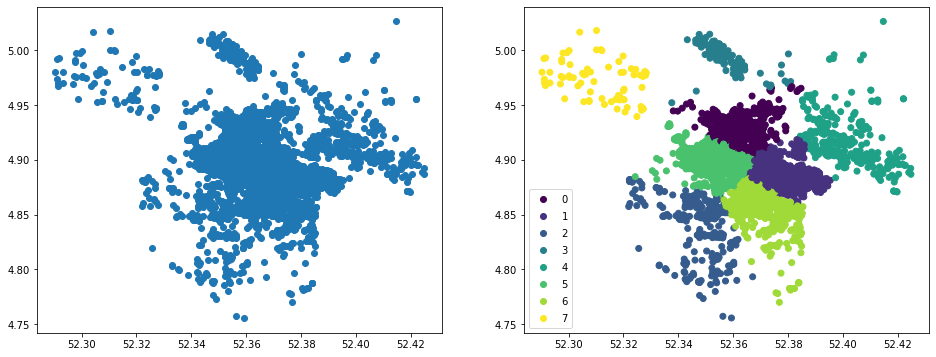

In [38]:
# transform latitude and longitude. We need to transform that into some clusters.

# how they spread geographically.
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (16,6))
ax1.scatter(X_train['latitude'], X_train['longitude'])

# implement k-means
geo_data = np.column_stack((X_train['latitude'],X_train['longitude']))
geo_data = StandardScaler().fit_transform(geo_data)
kmeans = KMeans(n_clusters = 8, random_state = 0).fit(geo_data)

# visualize cluster results
scatter = ax2.scatter(X_train['latitude'], X_train['longitude'], c = kmeans.labels_)
legend = ax2.legend(*scatter.legend_elements())

# implement into training set
X_train['longitude_latitude_cluster'] = kmeans.labels_
X_train = pd.get_dummies(X_train, columns = ['longitude_latitude_cluster'])
X_train.drop(columns = ['latitude','longitude'], inplace = True)

# implement into test set
geo_data_test = np.column_stack((X_test['latitude'],X_test['longitude']))
geo_data_test = StandardScaler().fit_transform(geo_data_test)
X_test['longitude_latitude_cluster'] = kmeans.predict(geo_data_test)
X_test = pd.get_dummies(X_test, columns = ['longitude_latitude_cluster'])
X_test.drop(columns = ['latitude','longitude'], inplace = True)

In [39]:
# transform instant_bookable
X_train['instant_bookable'] = X_train['instant_bookable'].replace({'t':1,'f':0})
X_test['instant_bookable'] = X_test['instant_bookable'].replace({'t':1,'f':0})

In [40]:
# transform has_availability
X_train['has_availability'] = X_train['has_availability'].replace({'t':1,'f':0})
X_test['has_availability'] = X_test['has_availability'].replace({'t':1,'f':0})

In [41]:
# transform property_type

l = []
for i in X_train['property_type'].value_counts().index:
    if X_train['property_type'].value_counts()[i] > 50:
        l.append(i)

# transform training set property_type

cleaned_property_type_train = []
for i in X_train['property_type']:
    if i in l:
        cleaned_property_type_train.append(i)
    else:
        cleaned_property_type_train.append('other')


cleaned_property_type_train = pd.Series(cleaned_property_type_train)
X_train['property_type'] = cleaned_property_type_train.values
X_train = pd.get_dummies(X_train, columns = ['property_type'])

# transform test set property_type

cleaned_property_type_test = []
for i in X_test['property_type']:
    if i in l:
        cleaned_property_type_test.append(i)
    else:
        cleaned_property_type_test.append('other')

cleaned_property_type_test = pd.Series(cleaned_property_type_test)
X_test['property_type'] = cleaned_property_type_test.values
X_test = pd.get_dummies(X_test, columns = ['property_type'])

# 3. EDA (visualizations)

Dear Teammates: 

Now data tranformation is finished. What ideas do we have for visualizaitons? My idea for now is to visualize columns like the sample I give. If anybody have any good ideas please announce in whatsapp!

In [59]:
df['property_type']

listingID
0       Private room in rental unit
1         Private room in townhouse
2         Private room in houseboat
3       Private room in rental unit
4       Private room in rental unit
                   ...             
5592     Entire condominium (condo)
5593                    Entire loft
5594                    Entire loft
5595             Entire rental unit
5596     Entire condominium (condo)
Name: property_type, Length: 5590, dtype: object

In [60]:
df['amenities'][1]

'["Fire extinguisher", "Carbon monoxide alarm", "Hangers", "Refrigerator", "Long term stays allowed", "Heating", "Hot water", "Wifi", "Host greets you", "Bed linens", "Dedicated workspace", "TV", "Smoke alarm", "Essentials", "Paid parking off premises", "Free street parking", "Hair dryer"]'

In [56]:
print(X_train.columns[:50])
print(X_train.columns[50:100])
print(X_train.columns[100:150])
print(X_train.columns[150:192])

Index(['neighborhood_overview', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',
       'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listin

In [54]:
df.columns

Index(['neighborhood_overview', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'r

In [61]:
df['neighbourhood_cleansed']

listingID
0       Oostelijk Havengebied - Indische Buurt
1                                 Centrum-Oost
2                                 Centrum-West
3                                 Centrum-West
4                                 Centrum-Oost
                         ...                  
5592                                      Zuid
5593                    De Baarsjes - Oud-West
5594                   De Pijp - Rivierenbuurt
5595                           Watergraafsmeer
5596                           Watergraafsmeer
Name: neighbourhood_cleansed, Length: 5590, dtype: object

In [45]:
df.columns

Index(['neighborhood_overview', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'r

Text(0.5, 1.0, 'Listings with neighborhood_overview')

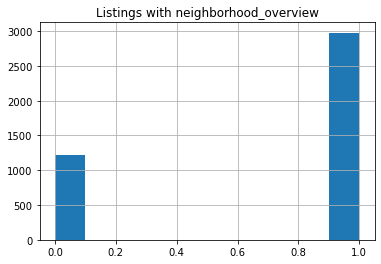

In [46]:
# here's a visualization example.
X_train['neighborhood_overview'].hist()
plt.title('Listings with neighborhood_overview')

# 4. Ordinary Least Squares

In [47]:
reg = LinearRegression().fit(X_train, y_train)
print('R-squared for training set is: ' + str(r2_score(y_train, reg.predict(X_train))))
print('Adjusted R-squared for test set is: ' + str(1 - (1 - reg.score(X_train, y_train)) * (4196)/(4196-191-1)))
print('R-squared for test set is: ' + str(reg.score(X_test, y_test)))
print('Adjusted R-squared for test set is: ' + str(1 - (1 - reg.score(X_test, y_test)) * (1399)/(1400-191-1)))

NameError: name 'r2_score' is not defined

In [ ]:
print('In training set, we can see both r-squared and adjusted r-squared are approximately 50%. In test set, r-sq')

In [ ]:
# does log transformation help?
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score
tt = TransformedTargetRegressor(regressor=LinearRegression(),
                           func=np.log1p, inverse_func=np.expm1)
tt.fit(X_train, y_train)

# log transformation slightly improved the performance on test set.
print('log transformed result gives r-squared for training set: ' + str(tt.score(X_train, y_train)))
print('log transformed result gives r-squared for test set: ' + str(tt.score(X_test,y_test)))